In [1]:
#Mustabeen Usman
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.7.0


[nltk_data] Downloading package stopwords to C:\Users\ZAIN
[nltk_data]     QADRI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  Dataset Preprocessing
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


You can see the columns are without any proper names. Lets rename them for our reference

In [3]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [5]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

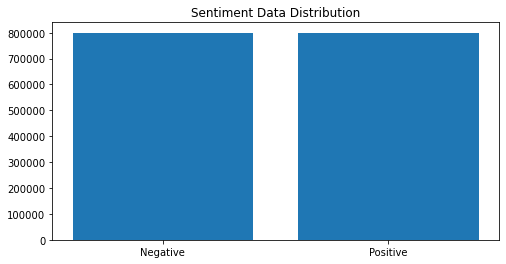

In [6]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. Thank Goodness.

Now let us explore the data we having here... 

In [7]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
177126,Negative,"Dang, I need a bed in the bay area Monday / Tu..."
453095,Negative,@brittianyerin Haha nice nice. Oh dear Matt is...
344243,Negative,"Its getting down to the wire, and now the only..."
976473,Positive,"@AliIkram smells pretty good, I'm afraid I am ..."
297085,Negative,Ohhh i wishhhh my computer worked how sadd
487362,Negative,"@kyl_e maybe. out of 12-15 pieces being shown,..."
658361,Negative,@JenniLaSuper fml? isn't that *uck My Life?!
900010,Positive,I have the Job this is a nice day it can not ...
863437,Positive,@iamjeffr already added you in fb
718640,Negative,Bets friend left Now Real Time with Bill Maher!


In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))

**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

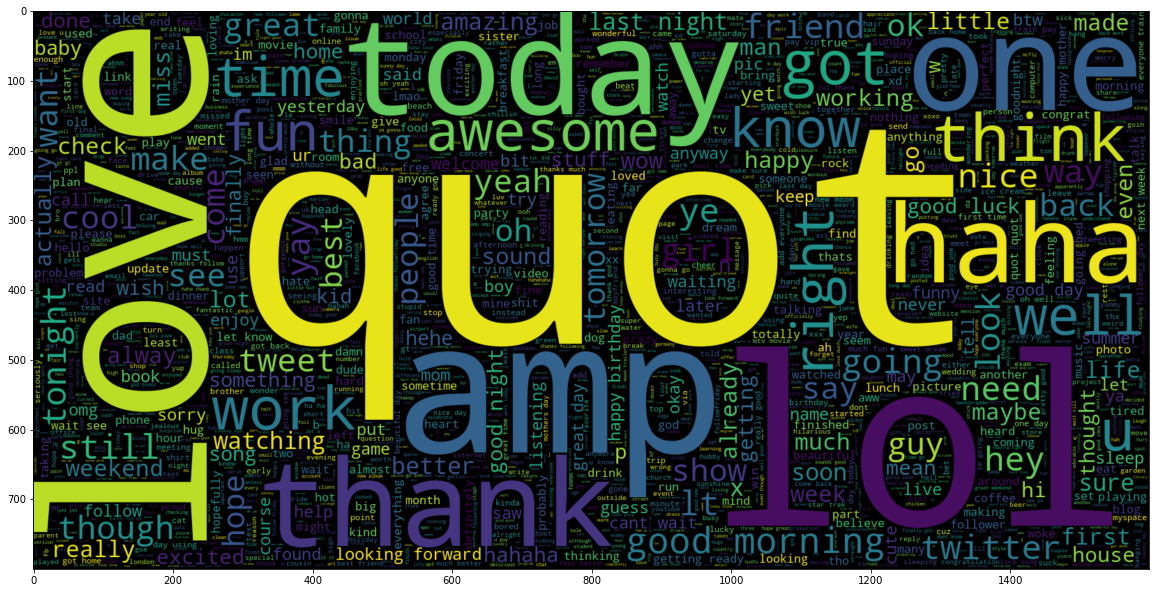

In [11]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

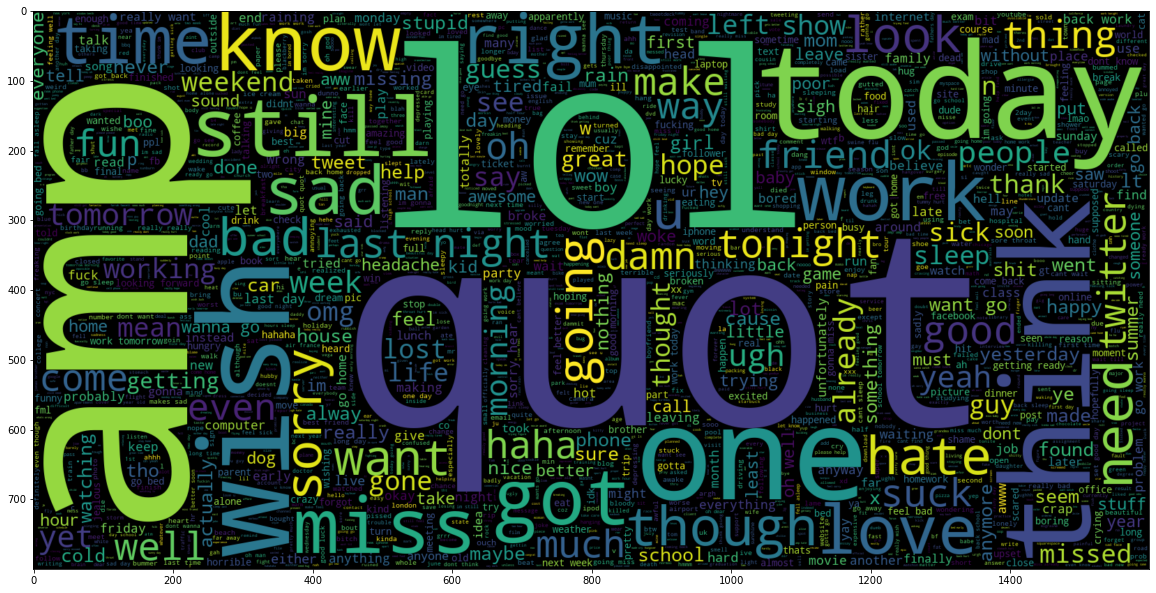

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [13]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [14]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [15]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [17]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [18]:
labels = train_data.sentiment.unique().tolist()

In [19]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [32]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 1
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [34]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [35]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [36]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [37]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [39]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on CPU...


In [40]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

1250/1250 [==============================] - 645s 513ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5017 - lr: 0.0010


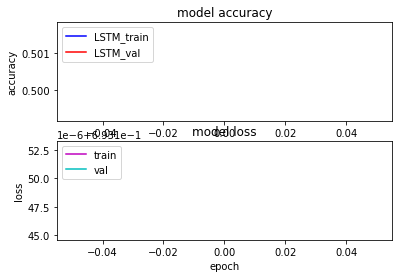

In [41]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [42]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 30s 913ms/step


In [43]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

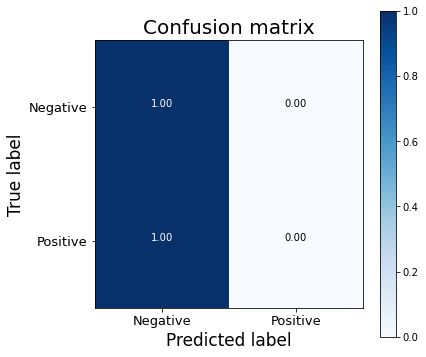

In [44]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [45]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

C:\Users\ZAIN QADRI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ZAIN QADRI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67    160542
    Positive       0.00      0.00      0.00    159458

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.34    320000



C:\Users\ZAIN QADRI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
